In [1]:
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

import lightgbm as lgbm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import pandas as pd

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [2]:
df = pd.read_parquet(os.path.join(os.pardir, "data", "ref", "yellow_tripdata_2021-01.parquet"))
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN


<Axes: xlabel='trip_duration', ylabel='Density'>

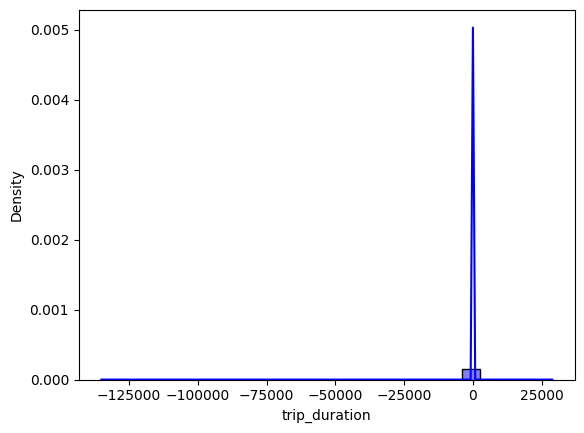

In [3]:
# create trip duration
# target variable
df["trip_duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
df["trip_duration"] = df["trip_duration"].dt.total_seconds() / 60.0
sns.histplot(df["trip_duration"], kde=True, stat="density", color='blue', bins=25, label='trip-duration')

In [4]:
# create a condition on target variable to predict duration time from 1 minute to 60 minute.
df = df[(df["trip_duration"] >=1) & (df["trip_duration"] <= 60)]
df.shape

(1343254, 20)

<Axes: xlabel='trip_duration', ylabel='Density'>

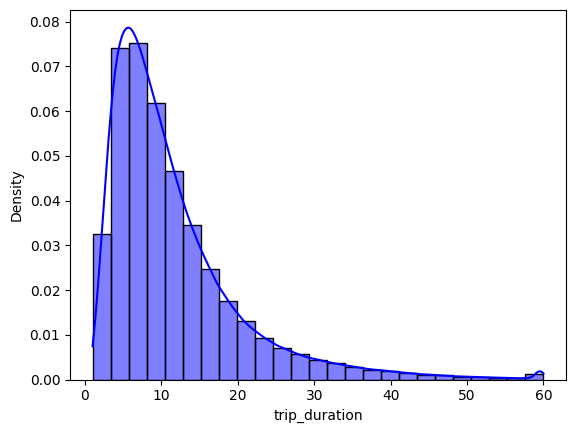

In [5]:
sns.histplot(df["trip_duration"], kde=True, stat="density", color='blue', bins=25, label='trip-duration')

In [6]:
# use the following features from available features.
final_df = df[["PULocationID", "DOLocationID", "trip_distance", "trip_duration"]]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343254 entries, 0 to 1369768
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   PULocationID   1343254 non-null  int64  
 1   DOLocationID   1343254 non-null  int64  
 2   trip_distance  1343254 non-null  float64
 3   trip_duration  1343254 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 51.2 MB


In [7]:
# search space of lightgbm regressor
SEARCH_SPACE={
    "n_estimators":scope.int(hp.quniform("n_estimators", 50, 700, 5)),
    "max_depth":scope.int(hp.quniform("max_depth", 1, 12, 1)),
    "num_leaves":scope.int(hp.quniform("num_leaves", 20, 100, 5)),
    "min_data_in_leaf":scope.int(hp.quniform("min_data_in_leaf", 9000, 10000, 300)),
    "min_gain_to_split":scope.float(hp.quniform("min_gain_to_split", 0.1, 15.0, 0.4)),
    "learning_rate":scope.float(hp.quniform("learning_rate", 0.01, 0.3, 0.001)),
    "lambda_l2":hp.loguniform("reg_alpha", -5, -1),
    "lambda_l1":hp.loguniform("reg_lambda", -6, -1),
    "objective":"regression",
    "seed":42
}

In [8]:
X = final_df.drop("trip_duration", axis = 1)
y = final_df["trip_duration"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
def optimize(params):
    booster = lgbm.LGBMRegressor(**params)
    booster.fit(X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric = "rmse",
                early_stopping_rounds = 20)
    y_pred = booster.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    return {"loss":rmse, "status":STATUS_OK}

In [10]:
best_res = fmin(
    fn = optimize,
    space = SEARCH_SPACE,
    algo = tpe.suggest,
    max_evals=10,
    trials=Trials()
)

[LightGBM] [Warning] lambda_l1 is set=0.2679478001591751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2679478001591751
[LightGBM] [Warning] lambda_l2 is set=0.085045510463706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.085045510463706
[LightGBM] [Warning] min_gain_to_split is set=12.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.0
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 7.80335	valid_0's l2: 60.8922     
[2]	valid_0's rmse: 6.96217	valid_0's l2: 48.4718     
[3]	valid_0's rmse: 6.30919	valid_0's l2: 39.8059     
[4]	valid_0's rmse: 5.81148	valid_0's l2: 33.7734     
[5]	valid_0's rmse: 5.43581	valid_0's l2: 29.548      
[6]	valid_0's rmse: 5.1572	valid_0's l2: 26.5967      
[7]	valid_0's rmse: 4.94787	valid_0's l2: 24.4815     
[8]	valid_0's rmse: 4.80039	valid_0's l2: 23.0438     
[9]	valid_0's rmse: 4.69166	valid_0's l2: 22.0117     
[10]	valid_0's rmse: 4.60432	valid_0's l2: 21.1997    
[11]	valid_0's rmse: 4.54283	valid_0's l2: 20.6373    
[12]	valid_0's rmse: 4.49769	valid_0's l2: 20.2292    
[13]	valid_0's rmse: 4.45299	valid_0's l2: 19.8291    
[14]	valid_0's rmse: 4.42166	valid_0's l2: 19.551     
[15]	valid_0's rmse: 4.40212	valid_0's l2: 19.3787    
[16]	valid_0's rmse: 4.38221	valid_0's l2: 19.2038    
[17]	valid_0's rmse: 4.36894	valid_0's l2: 19.0877    
[18]	valid_0's rmse: 4.35822	valid_0's l2: 18.9941    
[19]	valid

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 7.82807	valid_0's l2: 61.2787                              
[2]	valid_0's rmse: 7.00795	valid_0's l2: 49.1113                              
[3]	valid_0's rmse: 6.37231	valid_0's l2: 40.6064                              
[4]	valid_0's rmse: 5.88803	valid_0's l2: 34.6689                              
[5]	valid_0's rmse: 5.52648	valid_0's l2: 30.542                               
[6]	valid_0's rmse: 5.25724	valid_0's l2: 27.6386                              
[7]	valid_0's rmse: 5.0618	valid_0's l2: 25.6218                               
[8]	valid_0's rmse: 4.91714	valid_0's l2: 24.1783                              
[9]	valid_0's rmse: 4.81322	valid_0's l2: 23.1671                              
[10]	valid_0's rmse: 4.73783	valid_0's l2: 22.447                              
[11]	valid_0's rmse: 4.68354	valid_0's l2: 21.9355                             
[12]	valid_0's rmse: 4.63831	valid_0's l2: 21.5139                             
[13]	valid_0's rmse: 4.59378	valid_0's l

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 7.84543	valid_0's l2: 61.5508                              
[2]	valid_0's rmse: 7.06057	valid_0's l2: 49.8517                              
[3]	valid_0's rmse: 6.45405	valid_0's l2: 41.6548                              
[4]	valid_0's rmse: 6.00904	valid_0's l2: 36.1085                              
[5]	valid_0's rmse: 5.67506	valid_0's l2: 32.2064                              
[6]	valid_0's rmse: 5.43345	valid_0's l2: 29.5223                              
[7]	valid_0's rmse: 5.23489	valid_0's l2: 27.4041                              
[8]	valid_0's rmse: 5.10159	valid_0's l2: 26.0263                              
[9]	valid_0's rmse: 4.9964	valid_0's l2: 24.964                                
[10]	valid_0's rmse: 4.91868	valid_0's l2: 24.1934                             
[11]	valid_0's rmse: 4.85231	valid_0's l2: 23.5449                             
[12]	valid_0's rmse: 4.79669	valid_0's l2: 23.0083                             
[13]	valid_0's rmse: 4.7573	valid_0's l2

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 8.43088	valid_0's l2: 71.0797                              
[2]	valid_0's rmse: 8.02554	valid_0's l2: 64.4093                              
[3]	valid_0's rmse: 7.65539	valid_0's l2: 58.605                               
[4]	valid_0's rmse: 7.31932	valid_0's l2: 53.5725                              
[5]	valid_0's rmse: 7.01289	valid_0's l2: 49.1806                              
[6]	valid_0's rmse: 6.73602	valid_0's l2: 45.3739                              
[7]	valid_0's rmse: 6.48571	valid_0's l2: 42.0644                              
[8]	valid_0's rmse: 6.25922	valid_0's l2: 39.1779                              
[9]	valid_0's rmse: 6.05559	valid_0's l2: 36.6702                              
[10]	valid_0's rmse: 5.87207	valid_0's l2: 34.4812                             
[11]	valid_0's rmse: 5.70768	valid_0's l2: 32.5776                             
[12]	valid_0's rmse: 5.56149	valid_0's l2: 30.9302                             
[13]	valid_0's rmse: 5.43052	valid_0's l

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 8.4214	valid_0's l2: 70.92                                 
[2]	valid_0's rmse: 8.03502	valid_0's l2: 64.5616                              
[3]	valid_0's rmse: 7.69252	valid_0's l2: 59.1749                              
[4]	valid_0's rmse: 7.39796	valid_0's l2: 54.7299                              
[5]	valid_0's rmse: 7.13066	valid_0's l2: 50.8463                              
[6]	valid_0's rmse: 6.89931	valid_0's l2: 47.6005                              
[7]	valid_0's rmse: 6.68795	valid_0's l2: 44.7287                              
[8]	valid_0's rmse: 6.50609	valid_0's l2: 42.3292                              
[9]	valid_0's rmse: 6.33763	valid_0's l2: 40.1655                              
[10]	valid_0's rmse: 6.18921	valid_0's l2: 38.3064                             
[11]	valid_0's rmse: 6.05208	valid_0's l2: 36.6277                             
[12]	valid_0's rmse: 5.93064	valid_0's l2: 35.1725                             
[13]	valid_0's rmse: 5.82138	valid_0's l

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 7.62732	valid_0's l2: 58.176                               
[2]	valid_0's rmse: 6.7024	valid_0's l2: 44.9222                               
[3]	valid_0's rmse: 6.03173	valid_0's l2: 36.3818                              
[4]	valid_0's rmse: 5.55477	valid_0's l2: 30.8555                              
[5]	valid_0's rmse: 5.21928	valid_0's l2: 27.2409                              
[6]	valid_0's rmse: 4.99153	valid_0's l2: 24.9154                              
[7]	valid_0's rmse: 4.82784	valid_0's l2: 23.308                               
[8]	valid_0's rmse: 4.71958	valid_0's l2: 22.2744                              
[9]	valid_0's rmse: 4.64082	valid_0's l2: 21.5372                              
[10]	valid_0's rmse: 4.58718	valid_0's l2: 21.0422                             
[11]	valid_0's rmse: 4.53572	valid_0's l2: 20.5727                             
[12]	valid_0's rmse: 4.50222	valid_0's l2: 20.27                               
[13]	valid_0's rmse: 4.47706	valid_0's l

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 7.42924	valid_0's l2: 55.1936                              
[2]	valid_0's rmse: 6.42047	valid_0's l2: 41.2224                              
[3]	valid_0's rmse: 5.73913	valid_0's l2: 32.9376                              
[4]	valid_0's rmse: 5.29167	valid_0's l2: 28.0017                              
[5]	valid_0's rmse: 5.00262	valid_0's l2: 25.0262                              
[6]	valid_0's rmse: 4.81242	valid_0's l2: 23.1594                              
[7]	valid_0's rmse: 4.69444	valid_0's l2: 22.0377                              
[8]	valid_0's rmse: 4.61599	valid_0's l2: 21.3073                              
[9]	valid_0's rmse: 4.55102	valid_0's l2: 20.7118                              
[10]	valid_0's rmse: 4.51515	valid_0's l2: 20.3866                             
[11]	valid_0's rmse: 4.48289	valid_0's l2: 20.0963                             
[12]	valid_0's rmse: 4.46159	valid_0's l2: 19.9058                             
[13]	valid_0's rmse: 4.44777	valid_0's l

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 8.24046	valid_0's l2: 67.9052                              
[2]	valid_0's rmse: 7.68736	valid_0's l2: 59.0955                              
[3]	valid_0's rmse: 7.20696	valid_0's l2: 51.9403                              
[4]	valid_0's rmse: 6.79148	valid_0's l2: 46.1242                              
[5]	valid_0's rmse: 6.43208	valid_0's l2: 41.3716                              
[6]	valid_0's rmse: 6.12647	valid_0's l2: 37.5336                              
[7]	valid_0's rmse: 5.86354	valid_0's l2: 34.3811                              
[8]	valid_0's rmse: 5.6419	valid_0's l2: 31.831                                
[9]	valid_0's rmse: 5.45453	valid_0's l2: 29.7519                              
[10]	valid_0's rmse: 5.29586	valid_0's l2: 28.0461                             
[11]	valid_0's rmse: 5.16353	valid_0's l2: 26.6621                             
[12]	valid_0's rmse: 5.05347	valid_0's l2: 25.5376                             
[13]	valid_0's rmse: 4.95732	valid_0's l

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 8.76512	valid_0's l2: 76.8274                              
[2]	valid_0's rmse: 8.65799	valid_0's l2: 74.9608                              
[3]	valid_0's rmse: 8.55355	valid_0's l2: 73.1633                              
[4]	valid_0's rmse: 8.45157	valid_0's l2: 71.429                               
[5]	valid_0's rmse: 8.35235	valid_0's l2: 69.7617                              
[6]	valid_0's rmse: 8.2554	valid_0's l2: 68.1516                               
[7]	valid_0's rmse: 8.16111	valid_0's l2: 66.6038                              
[8]	valid_0's rmse: 8.0689	valid_0's l2: 65.1072                               
[9]	valid_0's rmse: 7.97898	valid_0's l2: 63.6642                              
[10]	valid_0's rmse: 7.89147	valid_0's l2: 62.2753                             
[11]	valid_0's rmse: 7.80589	valid_0's l2: 60.9319                             
[12]	valid_0's rmse: 7.72248	valid_0's l2: 59.6367                             
[13]	valid_0's rmse: 7.64113	valid_0's l

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[1]	valid_0's rmse: 8.70657	valid_0's l2: 75.8043                              
[2]	valid_0's rmse: 8.54768	valid_0's l2: 73.0628                              
[3]	valid_0's rmse: 8.39706	valid_0's l2: 70.5106                              
[4]	valid_0's rmse: 8.25413	valid_0's l2: 68.1306                              
[5]	valid_0's rmse: 8.11807	valid_0's l2: 65.9031                              
[6]	valid_0's rmse: 7.98898	valid_0's l2: 63.8238                              
[7]	valid_0's rmse: 7.86569	valid_0's l2: 61.8691                              
[8]	valid_0's rmse: 7.74858	valid_0's l2: 60.0406                              
[9]	valid_0's rmse: 7.63648	valid_0's l2: 58.3159                              
[10]	valid_0's rmse: 7.52939	valid_0's l2: 56.6918                             
[11]	valid_0's rmse: 7.42706	valid_0's l2: 55.1612                             
[12]	valid_0's rmse: 7.32911	valid_0's l2: 53.7159                             
[13]	valid_0's rmse: 7.23553	valid_0's l

In [11]:
best_res

{'learning_rate': 0.231,
 'max_depth': 6.0,
 'min_data_in_leaf': 9600.0,
 'min_gain_to_split': 5.2,
 'n_estimators': 340.0,
 'num_leaves': 45.0,
 'reg_alpha': 0.23235222706429914,
 'reg_lambda': 0.19011951059503468}

In [12]:
params = {'learning_rate': 0.231,
 'max_depth': 6,
 'min_data_in_leaf': 9600,
 'min_gain_to_split': 5.2,
 'n_estimators': 340,
 'num_leaves': 45,
 'reg_alpha': 0.23235222706429914,
 'reg_lambda': 0.19011951059503468}

In [13]:
booster = lgbm.LGBMRegressor(**params)
booster.fit(X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric = "rmse",
                early_stopping_rounds = 20)
y_pred = booster.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse

/home/codespace/.python/current/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=5.2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.2
[1]	valid_0's rmse: 7.43403	valid_0's l2: 55.2649
[2]	valid_0's rmse: 6.4248	valid_0's l2: 41.278
[3]	valid_0's rmse: 5.73806	valid_0's l2: 32.9253
[4]	valid_0's rmse: 5.29018	valid_0's l2: 27.986
[5]	valid_0's rmse: 4.99479	valid_0's l2: 24.9479
[6]	valid_0's rmse: 4.81039	valid_0's l2: 23.1398
[7]	valid_0's rmse: 4.69408	valid_0's l2: 22.0344
[8]	valid_0's rmse: 4.61826	valid_0's l2: 21.3284
[9]	valid_0's rmse: 4.5534	valid_0's l2: 20.7335
[10]	valid_0's rmse: 4.51719	valid_0's l2: 20.405
[11]	valid_0's rmse: 4.48492	valid_0's l2: 20.1145
[12]	valid_0's rmse: 4.4649	valid_0's l2: 19.9354
[13]	valid_0's rmse: 4.45142	valid_0's l2: 19.8152
[14]	valid_0's rmse: 4.44125	valid_0's l2: 19.7247
[15]	valid_0's rmse: 4.42974	valid_0's l2: 19.6226


4.129773210472587

In [14]:
# now let's validate using validation dataset of February..
test_df = pd.read_parquet(os.path.join(os.pardir, "data", "validation", "yellow_tripdata_2021-02.parquet"))
test_df["trip_duration"] = test_df["tpep_dropoff_datetime"] - test_df["tpep_pickup_datetime"]
test_df["trip_duration"] = test_df["trip_duration"].dt.total_seconds() / 60.0
test_df = test_df[(test_df["trip_duration"] >=1) & (test_df["trip_duration"] <= 60)]
test_df = test_df[["PULocationID", "DOLocationID", "trip_distance", "trip_duration"]]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1340859 entries, 0 to 1371708
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   PULocationID   1340859 non-null  int64  
 1   DOLocationID   1340859 non-null  int64  
 2   trip_distance  1340859 non-null  float64
 3   trip_duration  1340859 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 51.1 MB


In [15]:
X_test, y_test = test_df.drop("trip_duration", axis = 1), test_df["trip_duration"]

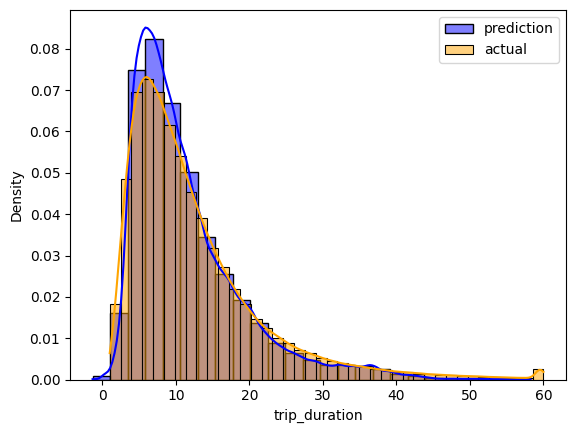

In [16]:
y_pred = booster.predict(X_test)
sns.histplot(y_pred, kde=True, stat="density", color='blue', bins=25, label='prediction')
sns.histplot(y_test, kde=True, stat="density", color='orange', bins=40, label='actual')
plt.legend()

In [17]:
# looks very gooood!!!
mean_squared_error(y_test, y_pred, squared=False)

4.745017238423267

In [18]:
# save the model
with open(os.path.join(os.pardir, "bin", "lgbm.pkl"), 'wb') as f:
    pickle.dump(booster, f)